In [ ]:
# first we created an s3 bucket

# Created a public access to it using bucket policy maker

# Downloaded using wget

#credits - https://www.simplified.guide/aws/s3/create-public-bucket

In [ ]:
!wget "https://apple-quality.s3.ap-south-1.amazonaws.com/apple_quality.csv"

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import lightgbm as lgb

In [9]:
df = pd.read_csv('apple_quality.csv')

In [10]:
df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [11]:
df['Quality'].value_counts()

Quality
good    2004
bad     1996
Name: count, dtype: int64

In [14]:
df.drop('A_id',axis=1,inplace=True)
df.reset_index(inplace=True)
df['index'] = df['index']+1
df.rename(columns={'index':'ID'},inplace=True)
X['Acidity'] = X['Acidity'].astype(float)

In [69]:
X = df.drop(['Quality',"ID"],axis=1).dropna()
y = df['Quality'].dropna()

In [70]:
le = LabelEncoder()
y = le.fit_transform(y)

In [84]:
X.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984


<Axes: >

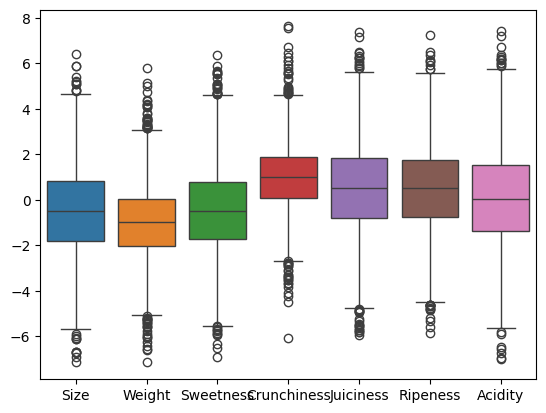

In [85]:
sns.boxplot(X)

#data is mostly scaled and will do the job

### Time to split the data

In [86]:
#first lets separate the test set
#we will take 3000 for training, 1000 for validation and test respectively

X_test,y_test = X[3501:],y[3501:]

In [87]:
X_train,X_val, y_train, y_val = train_test_split(X[:3501],y[:3501],test_size=0.15,shuffle=True)

In [88]:
X_val.shape,y_val.shape

((526, 7), (526,))

## LightGBM specific operations

In [105]:
train_data = lgb.Dataset(X_train, label=y_train,free_raw_data=False)
train_data.save_binary('lightgbm/train.bin')

[LightGBM] [Warning] File lightgbm/train.bin exists, cannot save binary to it


In [106]:
val_data = lgb.Dataset(X_val, label=y_val,free_raw_data=False)
val_data.save_binary('lightgbm/val.bin')
test_data = lgb.Dataset(X_test, label=y_test,free_raw_data=False)
test_data.save_binary('lightgbm/test.bin')

[LightGBM] [Warning] File lightgbm/val.bin exists, cannot save binary to it
[LightGBM] [Warning] File lightgbm/test.bin exists, cannot save binary to it


In [154]:
#now memory efficiently train, test, val is set

#we create the params

params = {'num_leaves':20,
          'objective':'multiclass',
          'num_threads':3,
          'metric':'softmax',
          'num_class':3,
          'learning_rate':0.01
          }

In [ ]:
lgb.cv()

In [161]:
lgb_cv = lgb.cv(params=params,
train_set=train_data,
num_boost_round=600,
nfold=5,
stratified=True,)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2380, number of used features: 7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2380, number of used features: 7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2380, number of used features: 7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013498 seconds.
You can set `force_col_wise=true` t

In [164]:
lgb_cv['valid multi_logloss-mean'].index(np.min(lgb_cv['valid multi_logloss-mean']))

599

In [153]:
lgboost_best = lgb.train(params=params,
                    train_set=train_data,
                    valid_sets=val_data,
                    num_boost_round=600)
lgboost_best.best_score

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2975, number of used features: 7
[LightGBM] [Info] Start training from score -0.698202
[LightGBM] [Info] Start training from score -0.688118
[LightGBM] [Info] Start training from score -34.538776


defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('multi_logloss', 0.24891853609897605)])})

In [145]:
lgboost_best.save_model('lightgbm/lgb.txt',num_iteration=lgboost_best.best_iteration)

In [166]:
preds = lgboost_best.predict(X_test)
y_pred= []
for i in preds:
    y_pred.append(np.argmax(i))

In [174]:
print(f"Accuracy is {accuracy_score(y_pred, y_test)}")

Accuracy is 0.8857715430861723


(None, 0.8893203883495144)

In [177]:
pd.crosstab(y_pred, y_test,colnames=['y_pred'],rownames=['y_true'])

y_pred,0,1
y_true,,
0,213,25
1,32,229


In [182]:
with open('lightgbm/lgb.pkl','wb') as f:
    pickle.dump(lgboost_best,f)